## 1. Problem statement

The following mini-project addresses the following problem:

Can we predict, or rather - how well can we predict the results of end-of-school exams (for primary school students) based on 6 mock exams that came beforehand?

We are given a data from 4 previous years.

Bad news - there are only 87 entries.


Good news - all these students were taught by the same teacher (with no major teaching changes throughout the years) and according to the same cirriculum (the "oldest" data comes from the first students to finish the school after the latest reform of education in Poland).

Our aim is to build a model that based on these diagnostic exams can predict the end-of-school result so that it can be used for current final year students for their self-assessment and being realistic about their exam results and therefore - choices of high schools they want to apply to.

#### Data overview

In [1]:
import numpy as np 
from numpy.linalg import inv
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import random
sns.set()
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from scipy import stats

df = pd.read_excel('data_clean.xlsx')
df = df.drop(columns = ['Unnamed: 0'])
X = df.iloc[:, 1:7]
y = df['wynik']
print(df.shape)
df.head()

(87, 8)


,rocznik,sesja I,X,XII,sesja II,II,III,wynik
0,19,77.0,53.0,63.0,75.0,75.0,61.0,60
1,19,85.0,69.0,97.0,93.0,91.0,88.0,93
2,19,41.0,31.0,33.0,48.0,66.0,36.0,50
3,19,78.0,81.0,83.0,70.0,94.0,91.0,93
4,19,26.0,22.0,53.0,25.0,41.0,21.0,27


Some data explanation:
* the first column ("rocznik") indicates the graduation year of a given student
* other columns represent different tests throughout the year and they are sorted by time 
* two of these are not classic mock exams but diagnostic tests provided by the textbook press - these are "sesja I" and "sesja II"
* mocks are named after the months they were taken in 
* "wynik" column contains scores of students in the final exam

#### Is this all the data we have?

Not entirely... 

We also have distributions of final year exams from 2019, 2020, 2021 and 2022 (these may be useful 
due to the fact that, as we can see on the graphs below, they don't seem to follow the same distribution).

2019


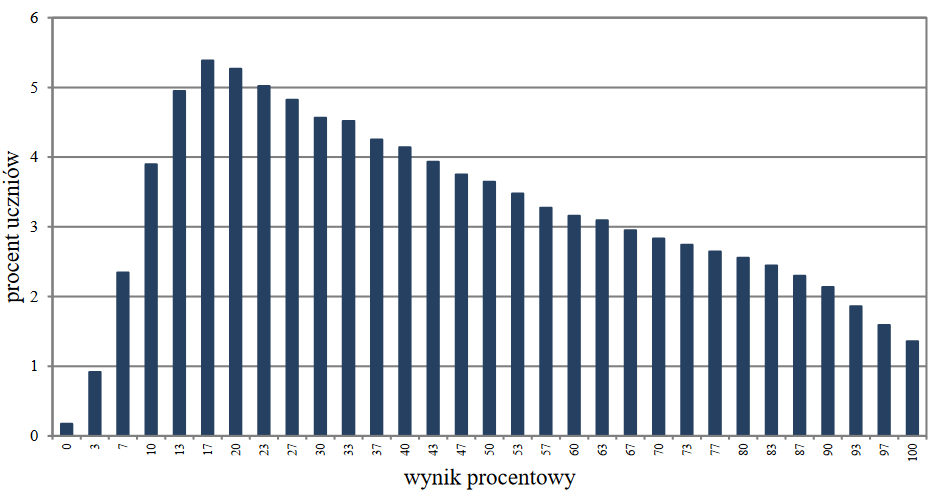

2020


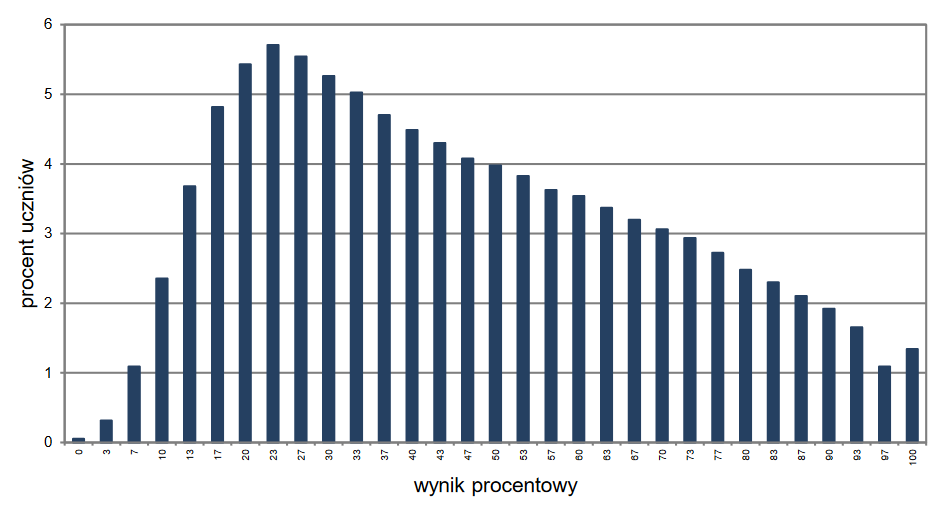

2021


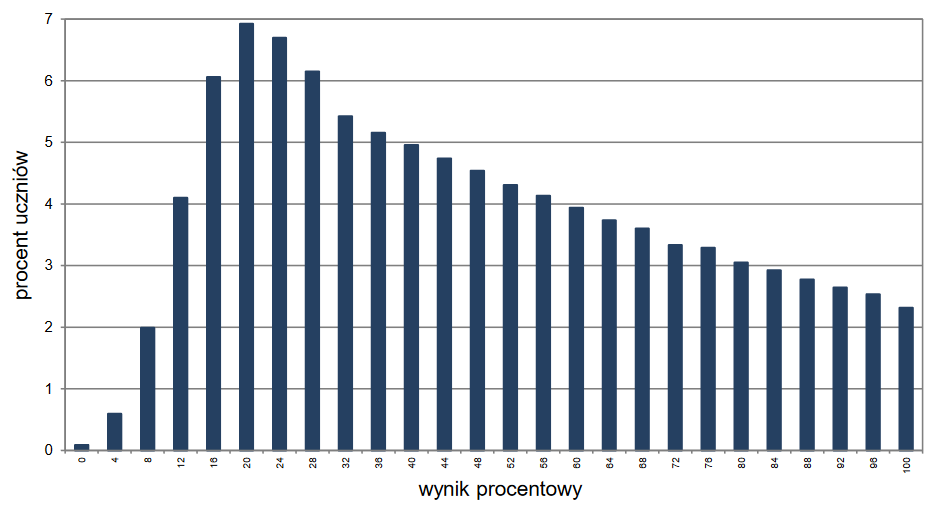

2022


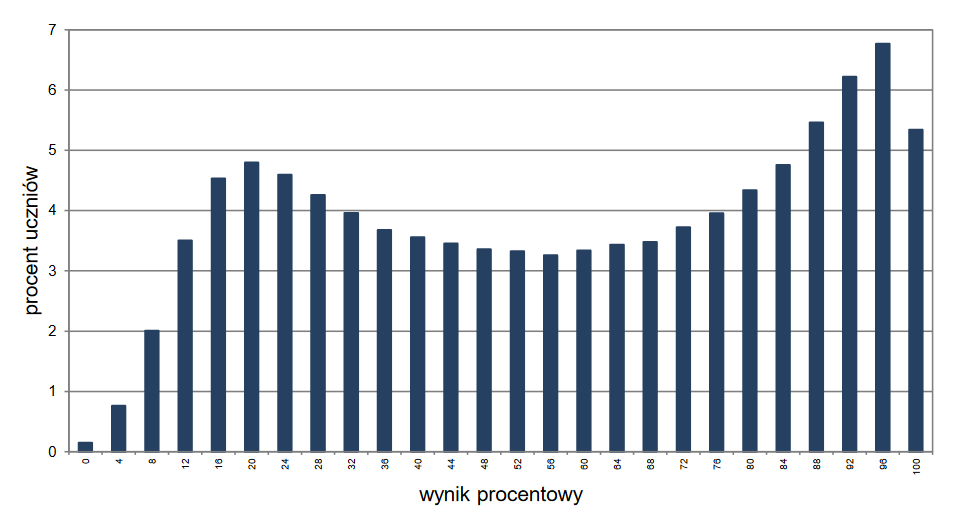

In [2]:
from IPython.display import Image
for yr in range(19,23):
    print('20'+str(yr))
    display(Image('exam' + str(yr) + '.png', width = 500)) 
    

## 2. Cross-validation issue

Before we start experimenting with any of the models, let's first address the cross-validation issue that this problem is facing. 

What's the problem?

Well, it would be tempting to use the usual sklearn's train-test-split, however this is not the solution we're looking for. You may ask ''Why?''. 

The main aim of this project is to be able to predict the final exam results for the **current** year that we neither know distribution of nor we can infer it from the data we have. At the same time, if we pick some portion of students from each year for our training set, then effectively during training we will be ''learning'' the distributions of the exams and correlations between inputs and output that hold for these particular years in particular but don't hold in general.

#### So what should we do?

Since our goal is to make predictions on a new, yet ''unknown'' year based on data from previous years, it seems that the only sensible way of carrying cross-validation is by picking one of four years of data, training the model on all but this data and then check the error on this year.

It seems to be the only working idea of how to do cross-validation sensibly on this dataset. Unfortunately, this may mean that we cannot really have a test set. Having one would mean that we forget about one whole year of data, make 3-fold instead of 4-fold cross-validation and suffer from lack of data even more than we do currently.

In [3]:
X_yr, y_yr = {}, {} #dev(=val) sets of X and y from a given year
X_slice, y_slice = {}, {} #training sets complimentary to X_yr and y_yr

for year in range(19,23):
    X_yr[year], y_yr[year] = X[df['rocznik'] == year], y[df['rocznik'] == year]
    X_slice[year], y_slice[year] = X[df['rocznik'] != year], y[df['rocznik'] != year]
    

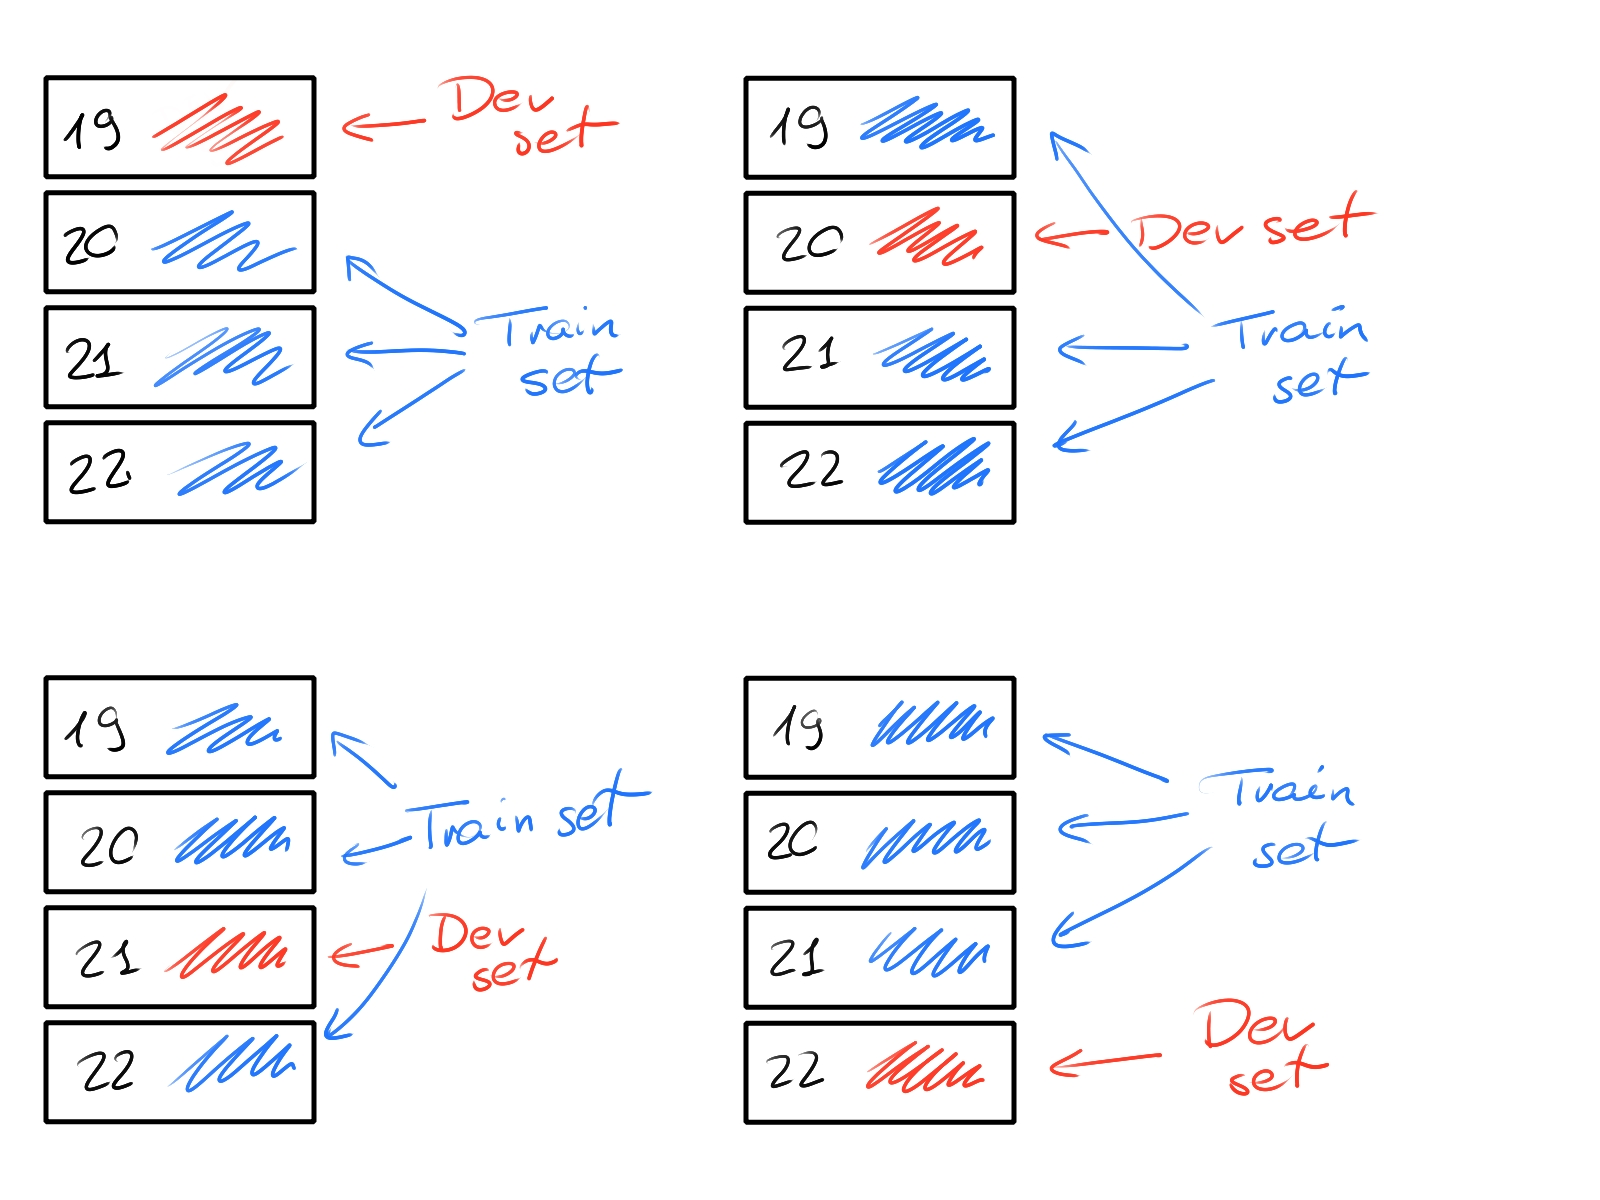

In [4]:
display(Image('cross-val.jpg', width = 500)) 

### 2.5. Evaluation metric

Since we have very few entries and have no test set, in order not to overfit to the dev set, 
we'll use mse for each dev set (which punishes big variance in error more than mae) and take not the 
mean but the **maximum** over the cross-valuation errors (the idea behind this choice is - we don't have test 
set, and we have very few data, so let's make the evaluation more brutal than usual to avoid overfitting).

## 3. Baseline models - linear regression


Due to scarcity of data, let's start with the models that are simple enough not to overfit. 
The simplest of them seems to be ''just take the average''. Since we don't need to fit the model, we can just see, how it works on our dataset.

In [5]:
print(mse(y, np.mean(X, axis = 1)))

501.24701468710094


We can generalise this idea into ''let's take the best possible average'', which is in some sense the version of linear regression but with condition on nonnegativity of weights together with condition that all the weights sum up to 1.

I haven't found way of modifying sklearn LinearRegression to include such conditions, hence here is my short implementation of how to achieve it using extension of the idea of Normal Equation solution to Linear Regression.

### 3.1 Restricted Linear Regression using Normal Equation + Lagrangian multipliers

We would like to minimize the function

$$\min_{w} \left|\left|y^T - X\cdot w\right|\right|^2\qquad\text{subject to }w^T\cdot 1 = 1$$

where 1 in the dot product denotes the all-ones vector of appropriate size.

Let's consider the function

$$L(w,\lambda) = \left|\left|y^T - X\cdot w\right|\right|^2+\lambda(w^T\cdot 1-1)$$

Using the idea of [Lagrange multipliers](https://en.wikipedia.org/wiki/Lagrange_multiplier) in order to 
find our minimum we would like to find the stationary point of $L(w,\lambda)$. To achieve this, we want 
$$\nabla L = -2X^Ty + 2X^TXw + \lambda$$
to be equal to $0$.

Hence, we want to find such a $\lambda, w$ that 
$$-2X^Ty+2X^TXw+\lambda = 0$$

For clarity, let's introduce the following notation:
$$A:=2X^TX,\quad b:=2X^Ty$$

Now, we can rewrite this problem in the following form:
$$-b + Aw + \lambda = 0$$
$$Aw=b-\lambda$$
$$w = A^{-1}(b-\lambda)$$

In case you wonder, yes - $\lambda$ is a scalar, but here I just write $\lambda$ for $\lambda\cdot 1$.
Therefore, we want to choose $\lambda$ in such a way that $w^T = 1$.

Can we do it?

I don't know how to do it explicitly, but we can just apply gradient descent using cost function:
$$J(\lambda) = (1^T\cdot A^{-1}(b-\lambda) - 1)^2$$

Finally, in order to make sure that all $w$ is in bounds $[0,1]$, let's penalize it for not falling into bounds:
$$J(\lambda) += \alpha\cdot\left|\left|max\left(0,\left|w - \frac{1}{2}\right|-\frac{1}{2}\right)\right|\right|^2$$
where $\alpha$ is a hyperparameter, using which we can give bigger emphasis on either non-negativity or sum-to-1 condition.


Now, let's see it in action.

In [6]:
def fun(lambda_, Ainv, b):   
    x = b - lambda_
    w = np.dot(Ainv, b-lambda_)
    sum_ = np.sum(w.flatten())
    J = (sum_ - 1)**2
    v = 1000 * np.maximum(0,np.abs(w - 1/2).flatten() - 1/2)
    v = v ** 2
    J += np.sum(v)
    return J

In [7]:
from scipy.optimize import minimize 
np.set_printoptions(precision=3)

err_train, err_dev = {}, {}
max_entry = {} #checking 'out-of-boundedness', see: next section

for year in range(19,23):
    X_train = X_slice[year]   
    y_train = y_slice[year]   
    A = 2 * np.dot(X_train.T, X_train)
    Ainv = inv(A)
    b = 2 * np.dot(X_train.T, y_train) # setting Ainv and b to optimize fun()
    
    lambda_ = 1
    min_ = minimize(fun, 1, args = (Ainv, b)) #fixing parameters Ainv and b
    lambda_ = min_.x
    
    x = b - lambda_
    w = np.dot(Ainv, b-lambda_)
    print('Weights: ' + str(w))
    max_entry[year] = np.max(np.dot(X_train, w))
    err_train[year] = mse(np.dot(X_train,w), y_train)
    err_dev[year] = mse(np.dot(X_yr[year], w), y_yr[year])
    print('Train error ' + str(year) + ': ' + str(err_train[year]))
    print('Dev error: ' + str(year) + ': ' + str(err_dev[year]) + '\n')
     
print('Average train error: ' + str(np.mean(list(err_train.values()))))
print('Average dev error: ' + str(np.mean(list(err_dev.values()))))


Weights: [ 0.311 -0.026  0.4   -0.026  0.296  0.376]
Train error 19: 198.68449581695847
Dev error: 19: 463.65393671978813

Weights: [ 0.126  0.004  0.065 -0.015  0.461  0.523]
Train error 20: 211.20943237920744
Dev error: 20: 155.59044598782083

Weights: [2.085e-01 1.168e-04 1.482e-01 2.600e-02 3.259e-01 5.187e-01]
Train error 21: 218.36893337206806
Dev error: 21: 129.63687130960182

Weights: [0.158 0.249 0.044 0.168 0.139 0.398]
Train error 22: 122.29885511768225
Dev error: 22: 444.1626930396767

Average train error: 187.64042917147907
Average dev error: 298.2609867642219


Before we go any further, let's just check how much error is due to ''bounds overflow'', i.e. the outputs greater than 100.

In [8]:
for year in range(19,23):
    print('Max entry in 20' + str(year) + ': ' + str(max_entry[year]))

Max entry in 2019: 126.65302684471806
Max entry in 2020: 114.75907314420222
Max entry in 2021: 119.46499246487511
Max entry in 2022: 106.61579211905514


Let's trim our predictions and at the final step of model by setting result = min(result, 100)

In [9]:
from scipy.optimize import minimize 
np.set_printoptions(precision=3)

err_tr_reslinreg, err_dev_reslinreg = [], []
max_entry = {} 
reslinreg_pred = []

for year in range(19,23):
    X_train = X_slice[year]   
    y_train = y_slice[year]   
    A = 2 * np.dot(X_train.T, X_train)
    Ainv = inv(A)
    b = 2 * np.dot(X_train.T, y_train) # setting Ainv and b to optimize fun()
    
    lambda_ = 1
    min_ = minimize(fun, 1, args = (Ainv, b)) #fixing parameters Ainv and b
    lambda_ = min_.x
    
    x = b - lambda_
    w = np.dot(Ainv, b-lambda_)
    print('Weights: ' + str(w))
    max_entry[year] = np.max(np.dot(X_train, w))
    
    y_train_pred = np.dot(X_train, w)
    y_train_pred = np.minimum(y_train_pred, 100)    
    y_dev_pred = np.dot(X_yr[year], w)
    y_dev_pred = np.minimum(y_dev_pred, 100)
    
    err_tr_reslinreg.append(mse(y_train_pred, y_train))
    err_dev_reslinreg.append(mse(y_dev_pred, y_yr[year]))
    
    reslinreg_pred.extend(y_dev_pred)
    
    print('Old train error ' + str(year) + ': ' + str(err_train[year]))
    print('New train error ' + str(year) + ': ' + str(err_tr_reslinreg[-1]))
    print('Old dev error: ' + str(year) + ': ' + str(err_dev[year]))
    print('New dev error: ' + str(year) + ': ' + str(err_dev_reslinreg[-1]) + '\n')
     
print('Old average train error: ' + str(np.mean(list(err_train.values()))))
print('New average train error: ' + str(np.mean(err_tr_reslinreg)))
print('Old average dev error: ' + str(np.mean(list(err_dev.values()))))
print('New average dev error: ' + str(np.mean(err_dev_reslinreg)))

Weights: [ 0.311 -0.026  0.4   -0.026  0.296  0.376]
Old train error 19: 198.68449581695847
New train error 19: 144.0297143025182
Old dev error: 19: 463.65393671978813
New dev error: 19: 382.716276284001

Weights: [ 0.126  0.004  0.065 -0.015  0.461  0.523]
Old train error 20: 211.20943237920744
New train error 20: 196.57923951681911
Old dev error: 20: 155.59044598782083
New dev error: 20: 151.35964491349895

Weights: [2.085e-01 1.168e-04 1.482e-01 2.600e-02 3.259e-01 5.187e-01]
Old train error 21: 218.36893337206806
New train error 21: 193.23492584188122
Old dev error: 21: 129.63687130960182
New dev error: 21: 108.33800765819012

Weights: [0.158 0.249 0.044 0.168 0.139 0.398]
Old train error 22: 122.29885511768225
New train error 22: 120.25745033282381
Old dev error: 22: 444.1626930396767
New dev error: 22: 433.31781228106286

Old average train error: 187.64042917147907
New average train error: 163.5253324985106
Old average dev error: 298.2609867642219
New average dev error: 268.93293

Summing up the idea of restricted linear regression compared to bare average approach.

Good news: Algorithm fits the data nicely and average dev error went down.

Bad news: There is quite a big gap between train and dev error. Trimming did a small progress but not that much. Also, the train-dev gaps vary quite a lot.

Maybe good news?: When it comes to the last issue (gap varying), it happened e.g. in 2022, where we've seen that the final exam was easier than previous and had significantly different distribution from previous years. Hence, it may be an issue that may be beyond our reach.

One last remark on this method. You may say ''Hey, you didn't normalise!''. It was partly due to the model we've considered above. Since we want to find ''the best possible average'', i.e. impose conditions on weights w to be nonnegative and sum up to 1, we cannot normalize - after normalization mapping, the corresponding weights would have each different interval conditions and the condition about sum equal 1 would completely go astray. 

In [10]:
# In order to later see on examples how different models behave, we will now make a new dataframe - df_pred, which will 
# have additional columns contanining predictions of various models.
df_pred = df.copy()
df_pred['avg'] = np.mean(X, axis = 1)
df_pred['reslinreg_pred'] = reslinreg_pred
df_pred

,rocznik,sesja I,X,XII,sesja II,II,III,wynik,avg,reslinreg_pred
0,19,77.0,53.0,63.0,75.0,75.0,61.0,60,67.333333,90.872256
1,19,85.0,69.0,97.0,93.0,91.0,88.0,93,87.166667,100.000000
2,19,41.0,31.0,33.0,48.0,66.0,36.0,50,42.500000,56.912148
3,19,78.0,81.0,83.0,70.0,94.0,91.0,93,82.833333,100.000000
4,19,26.0,22.0,53.0,25.0,41.0,21.0,27,31.333333,48.044620
...,...,...,...,...,...,...,...,...,...,...
82,22,69.0,87.0,88.0,91.0,92.0,93.0,100,86.666667,100.000000
83,22,67.0,57.0,56.0,65.0,84.0,70.0,84,66.500000,77.634014
84,22,64.0,80.0,84.0,71.0,84.0,100.0,96,80.500000,97.038746
85,22,71.0,77.0,64.0,94.0,68.0,87.0,100,76.833333,93.004604


### 3.2 Back to normal linear models

Let's check how the data behaves when confronted with fully-fletched linear regression.

In [11]:
err_tr_linreg, err_dev_linreg = [], []
linreg_pred = []

for year in range(19,23):
    X_train, y_train = X_slice[year], y_slice[year]
    X_dev, y_dev = X_yr[year], y_yr[year]    
    
    linreg = LinearRegression()
    linreg.fit(X_train, y_train)
    print('Weights: ' + str(linreg.coef_) + ', '+ str(linreg.intercept_))
    
    y_train_pred = np.minimum(linreg.predict(X_train), 100)
    y_dev_pred = np.minimum(linreg.predict(X_dev), 100)
    
    err_tr_linreg.append(mse(y_train_pred, y_train))
    err_dev_linreg.append(mse(y_dev_pred, y_dev))
    
    linreg_pred.extend(y_dev_pred)
    
    print('Train error: ' + str(err_tr_linreg[-1]))
    print('Dev error: ' + str(err_dev_linreg[-1]) + '\n')
    
print('Average linreg train error: ' + str(np.mean(err_tr_linreg)))
print('Average linreg dev error: ' + str(np.mean(err_dev_linreg)))

df_pred['linreg_pred'] = linreg_pred
df_pred.to_excel('df_pred.xlsx')

Weights: [ 0.124 -0.036  0.279 -0.085  0.154  0.224], 43.15995859430703
Train error: 88.70507797173565
Dev error: 534.3835279671998

Weights: [ 0.053  0.036 -0.006  0.059  0.173  0.405], 33.106076472956204
Train error: 152.0587255401507
Dev error: 134.96772037178178

Weights: [ 0.009 -0.079  0.059  0.06   0.209  0.421], 34.94219726252717
Train error: 152.57042323165078
Dev error: 133.8714289664105

Weights: [0.118 0.245 0.047 0.143 0.083 0.335], 13.030209403180017
Train error: 113.38303574671932
Dev error: 364.58287670850456

Average linreg train error: 126.6793156225641
Average linreg dev error: 291.95138850347416


Although general linear regression does better job fitting the training set (no surprise), we see that it has similar average train error. What's more, dev error has more variance with max being 534 - much higher than restricted linreg's max error 433. Also, good news, the best model knows it's good to have non-negative weights (negative ones would be quite worrying - they would effectively say that the better a student writes certain test the worse is their predicted final 
result - absurd!)

## 4. More basic models  - overview

In Basic_models.ipynb I have tested additional basic models - Decision Trees, Random Forest, XGBoost (Random Forest and XGBoost of depth 1 in order to avoid overfitting to dev set) together with a little hyperparameter tuning and feature selection. Here are the obtained results:

In [12]:
data ={}
col_names = ['Name', 19, 20, 21, 22, 'total']

data = [['Restricted Linear Regression'] + [int(x) for x in err_dev_reslinreg] + [int(np.max(err_dev_reslinreg))],
       ['Linear Regression'] + [int(x) for x in err_dev_linreg] + [int(np.max(err_dev_linreg))]]

models = pd.DataFrame(data, columns = col_names)
models_add = pd.read_excel('basic_models.xlsx').drop(columns = ['Unnamed: 0'])

models = pd.concat([models, models_add], ignore_index=True)
models

,Name,19,20,21,22,total
0,Restricted Linear Regression,382,151,108,433,433
1,Linear Regression,534,134,133,364,534
2,Decision tree,507,241,282,387,507
3,Random forest,445,160,207,266,445
4,XGBoost,354,135,158,368,368


Restricted Linear Regression is a hard model to beat. I can see at least two reasons for such a situation:
* Years 19 and 22 seem to follow different distribution (observation based on high dev error in all the models) and there may be an error that is unavoidable due to the fact that we want to essentially ''guess'' the final distribution based on the other distributions (what's more, "stronger" models may be punished more in this case, since they fit better to the training data, hence deviating even more from the unseen year distribution).
* Dealing with percentage scores seems not a valid idea in the case of this problem, since it ignores the relative difficulty of getting different results in the final exam. Maybe we should deal with percentiles instead?

The latter of this points seems like a thought we could act on and, hopefully, find better models. This is what the next section is about.

Now you may say (as my flatmate did) ''But how is it even remotely possible that Decision tree of depth = 1 is better than taking average over all mocks? Let's see these methods on randomly sampled 15 students.

In [13]:
sample = random.sample(range(X.shape[0]), 15)
df_pred_all = pd.read_excel('df_pred_full.xlsx')
display(df_pred_all.iloc[sample, [8,9,12]])

,wynik,avg,tree_pred
52,96,63.166667,81.585366
19,70,56.333333,58.090909
16,47,49.500000,86.714286
5,37,41.333333,67.333333
37,44,19.750000,70.566667
39,92,72.166667,70.566667
8,57,51.000000,67.333333
43,68,65.000000,90.585366
35,100,64.833333,86.714286
53,88,42.166667,81.585366


And here is a display of all the methods compared to each other (on sample of 10 in order not to drown under the volume of numbers).

In [14]:
sample = random.sample(range(X.shape[0]), 10)
display(df_pred_all.iloc[sample, 8:])

,wynik,avg,reslinreg_pred,linreg_pred,tree_pred,forest_pred,xgb_pred
25,53,49.166667,62.856783,75.359052,86.714286,78.942960,68.807510
43,68,65.000000,81.861815,83.321612,90.585366,87.623149,85.492714
3,93,82.833333,100.000000,100.000000,89.250000,89.613414,90.208115
69,80,29.000000,33.109115,40.578299,50.727273,50.602195,50.550472
47,40,33.333333,45.095505,62.764692,70.566667,68.505173,64.245895
38,76,58.500000,77.393012,82.772329,90.585366,87.623149,85.492714
78,88,73.000000,89.353244,88.316939,81.585366,83.225178,82.357155
63,96,62.333333,70.878301,71.596219,81.585366,78.244987,73.946053
42,76,61.166667,82.505650,83.369077,70.566667,82.010115,77.933311
48,60,55.666667,76.551280,83.192893,70.566667,82.010115,74.088554


## 5. Data transformations

Here is the distribution data from final exams for each year:

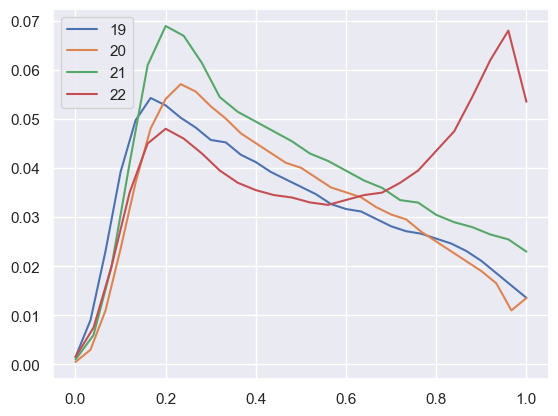

In [15]:
data = {}
sum_ = {}
exam = {}

data[19] = np.array([0.15, 0.9, 2.3, 3.9, 4.95, 5.4, 5.25, 5, 4.8, 4.55, 4.5, 4.25, 4.1, 3.9, 3.75, 3.6, 3.45, 3.25, 3.15, 3.1,
                2.95, 2.8, 2.7, 2.65, 2.55, 2.45, 2.3, 2.1, 1.85, 1.6, 1.35])
data[20] = np.array([0.05, 0.3, 1.1, 2.35, 3.7, 4.8, 5.4, 5.7, 5.55, 5.25, 5, 4.7, 4.5, 4.3, 4.1, 4, 3.8, 3.6, 3.5, 3.4, 3.2, 3.05,
                    2.95, 2.7, 2.5, 2.3, 2.1, 1.9, 1.65, 1.1, 1.35])
data[21] = np.array([0.1, 0.6, 2, 4.1, 6.1, 6.9, 6.7, 6.15, 5.45, 5.15, 4.95, 4.75, 4.55, 4.3, 4.15, 3.95, 3.75, 3.6, 3.35, 3.3, 3.05, 2.9, 2.8, 2.65, 2.55, 2.3])
data[22] = np.array([0.15, 0.75, 2, 3.5, 4.5, 4.8, 4.6, 4.3, 3.95, 3.7, 3.55, 3.45, 3.4, 3.3, 3.25, 3.35, 3.45, 3.5, 3.7, 3.95, 4.35, 4.75, 5.45, 6.2, 6.8, 5.35])

for year in range(19,23):
    sum_[year] = np.sum(data[year])
    data[year] = data[year]  / sum_[year]
    exam[year] = {'perc': data[year]}
    exam[year] = pd.DataFrame(exam[year])
    eps = 1 / (len(data[year]) - 1)
    range_ = np.arange(0, 1.001, step = eps)
    
    plt.plot(range_, exam[year], label = str(year))
    plt.legend()

In order to be able to convert smoothly between scores and percentiles, let's generate data that will simulate our distribution.

In [16]:
sim_data = {} #
for year in range(19,23):
    sim_data[year] = []
    for i in range(len(data[year])):
        for j in range(int(1000 * data[year][i] + 0.01)):
            sim_data[year].append(i/(len(data[year])-1))

Now the idea is following - we've got the data about distributions and it may be beneficial not to predict scores from 
input scores but map it all into percentiles, since they convey the information about how the data is distributed in our 
problem, e.g. the info that there is a pick around 20%.

In models_vardata.ipynb I have transformed the code from basic_models.ipynb, so that it could be fed with different data (so that we can explore various percentile transformations) and here is what we know:

In [17]:
df_perc = pd.read_excel('score_perc_score.xlsx')
df_perc = df_perc.drop(columns = ['Unnamed: 0'])
df_perc

,Name,19,20,21,22,total
0,Linear Regression,747,217,254,674,747
1,Decision tree,567,334,339,749,749
2,Random forest,569,195,193,692,692
3,XGBoost,513,187,144,520,520


These are the results that we get when we first map our data into percentiles, then train a model and then go back to scores (note: training and dev data are transformed into percentiles using different distributions, since dev data cannot ''know'' distribution from the year that it originates from).

Unfortunately, this approach doesn't seem to be that much beneficial. We are not even close to performing as well as with the original data.

Let's look out of curiosity how it would go if we just intended to predict percentiles from percentiles (should be at least a little bit better, since we don't gain error from score-percentile conversion; I know that percentiles and scores are differently distributed, however they are both on similar scale, i.e. [0,100] and their mse's should be within the same ranges).

In [18]:
df_perc_to_perc = pd.read_excel('perc_to_perc.xlsx')
df_perc_to_perc = df_perc_to_perc.drop(columns = ['Unnamed: 0'])
df_perc_to_perc

,Name,19,20,21,22,total
0,Restricted Linear Regression,761,174,196,396,761
1,Linear Regression,739,228,272,360,739
2,Decision tree,635,369,313,442,635
3,Random forest,579,188,194,395,579
4,XGBoost,409,158,164,415,415


It seems that even the idea of mapping percentiles to percentiles seems invalid.
But this may come from 2 sources:
* The idea that percentile to percentile mapping should be more natural and give you more information than plain score to score mapping may be not the way to go.
* The difference between distributions of exams in distinct years may be big enough to cause significant difference between percentile mappings for train and dev data, hence causing error.

These two approaches convey different messages - first one is saying "nope, we cannot really hope to get anything useful 
from the information about distributions". The second, on the other hand, suggests that the main reason 
for such bad performance may not be within the usage of percentiles per se but just this invalid dev set percentile-score
mapping using the distributions that do not belong to this year.

Can we somehow use the distribution information to our advantage without the need to go through the 
score$\to$percentile$\to$percentile$\to$score mapping?

The answer is ''Yes''.

To see the idea, note that actually we're dealing with a very specific and small sample, whose distribution by no means reflects the 
distribution of the exam for the whole Poland.  
Therefore, let's try augmenting some data so that we can actually pass to the model information about ''how 
exams behave in general''.

The idea is the following - for each student (in training set) in year Y, map their scores to percentiles using 
distribution of final exams in year Y, then make their ''shadow'', i.e. flip $p$-th percentile to $1-p$-th percentile and map 
back to scores.
This way we use the information about exam distributions but only in the training set and hence don't impose any errors 
due to mapping data to/from percentiles using distributions from different years but at the same time we are 
actually using the information that we get from these distributions.

Let's see the results:

In [19]:
df_aug = pd.read_excel('model_aug.xlsx')
df_aug = df_aug.drop(columns = ['Unnamed: 0'])
df_aug

,Name,19,20,21,22,total
0,Restricted Linear Regression,669,238,441,139,669
1,Linear Regression,366,288,249,488,488
2,Decision tree,483,394,447,562,562
3,Random forest,264,494,239,438,494
4,XGBoost,246,348,215,334,348


Finally!

We managed to beat the result that we got from normal (i.e. not transformed) data.
Let's see whether we can refine this idea even more.

## 6. Even more data augmentation!

One thought about exam distributions.

The percentile mapping seems to be a valid idea due to the fact that - well, linear ideas shouldn't be working well 
with this dataset.
Why? Because essentially what we would like our model to do is to say ''Student A started this year quite badly, had 40% from the first exam, however we see quite a progress in their actions - the subsequent mocks went far better so we will predict the final score for 75%''

So why not linear? Well, it would mean that we think that essentially whatever your score is, getting 5% better result 
requires the same amount of effort no matter whether you score 20%, 50% or 80%. Due to non-uniformity of distribution of final exams this 
doesn't seem to be a valid hypothesis.

What should we do then instead?

Well, it seems a reasonable idea that if we make mock exams based on the material that the students have learned, then 
no matter if the test is in September, February or May the overall distributions for the whole country should behave 
roughly the same. In other words, the percentage of students ''leaving'' given percentage of score and ''arriving at'' 
given percentage of score should be equal (for the distributions to remain equal).

Generalising this viewpoint, let's make a bold hypothesis that for any student it is equally likely to jump in his 
results by $p$ percentiles up no matter where his abilities are currently (and similarly down).

You may counterargue this fact by saying ''Nah, that's not true, if you give me a weak student, it will be much easier for 
me to train him to make 10 percentile leap than to do the same with a good student''.
Well, that's true but you must take into consideration that we are not supposed to estimate how easy it is to train 
certain student by a certain level but to estimate how easy it is for the student to train themselves by a certain 
level.

So yes, that's true that weak students have much more room for development but on the other hand, since we are looking 
from the country-wise perspective, they may be from countryside, where they have much worse educational support or 
 suffer from math anxiety.

These are the reasons that make the hypothesis about uniform difficulty of percentile progress believable.

#### Getting this idea to action

''How can we use it?'' you may ask.

The first idea that comes to mind is the following - if you look at the correlation of the scores, this is what you can notice:

<Axes: >

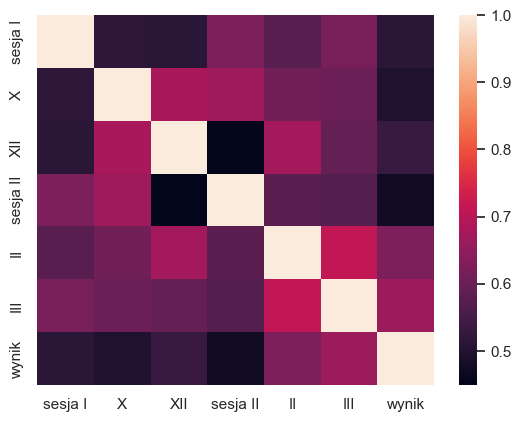

In [20]:
corr_matrix = pd.DataFrame(df.iloc[:,1:]).corr()
sns.heatmap(corr_matrix)

We see that most of the tests are most correlated with 2/3 test that happened just before them.
Therefore, we could rephrase our problem and try to predict the percentile result of the 4th test in a row based on 
the previous three.

Due to percentile invariance (i.e. hypothesis above), we could translate by a vector our first triple of percentiles 
so that the first entry equals 0. Then, by means of scaling (another bold hypothesis: it seems that if we have student 
with certain percentile gains, then there could exist the student with exactly half of these percentile gains)
we could assume that the second entry equals 1.

Therefore, the problem of 3 inputs predict 1 would actually boil down to 1 dimensional prediction problem after normalizing 
triples. Also, we would have 4 times as much data as we have now, since each student gives us 7 inputs, which in turn 
result in 4 in-a-row quadruples (triple + output).

"Yay! So cool! You may say, let's go, let's do it!" you may say

But unfortunately it is not the way to go. We have already seen in the previous data transformations 
that any ideas of the form score $\to$ percentiles $\to$ percentiles $\to$ score is doomed to fail 
due to differences in the percentile-score mappings of training and dev set.

However, the last tested approach showed that we can hope for some nice results if we just don't touch the dev set, i.e.
produce model that goes straight from the score to the score.

#### Score $\to$ score approach

How can we use the ideas above but without getting that much ''down to the percentiles world''?

We can use our hypothesis of percentile invariance. The same way that we made ''shadows'' of the students,
we can now make several ''translations'' of students.
So that we can now take a student, map their scores to percentiles, add to each of the percentiles some $p$, 
then map back to scores - and this is the score of this student's "translation".

Let's see how it works in action (code, as usual, in Models_vardata).

In [21]:
df_trans = pd.read_excel('models_trans.xlsx')
df_trans = df_trans.drop(columns = ['Unnamed: 0'])
df_trans

,Name,19,20,21,22,total
0,Restricted Linear Regression,444,147,109,477,477
1,Linear Regression,522,144,130,432,522
2,Decision tree,489,404,200,448,489
3,Random forest,446,118,168,276,446
4,XGBoost,367,121,140,369,369


Nice! Let's maybe merge now both "shadows" and "translations" approaches.

In [22]:
df_trans_aug = pd.read_excel('model_trans_aug.xlsx')
df_trans_aug = df_trans_aug.drop(columns = ['Unnamed: 0'])
df_trans_aug

,Name,19,20,21,22,total
0,Restricted Linear Regression,750,309,224,347,750
1,Linear Regression,347,280,244,486,486
2,Decision tree,360,308,229,407,407
3,Random forest,437,436,450,534,534
4,XGBoost,212,233,120,368,368


Unfortunately this doesn't leed to any sensible results (however, in case of XGBoost it is mainly the fault of this evil year of '22).

### 7. And the winner is...

It seems that the best approach out of the ones tested the best is XGBoost with shadow augmentation.
In the whole notebook we used as our metric the maximum of the mean squared error in order to punish any 
forms of high variance in the outcome error and thus to prevent ourselves from overfitting, which could be 
very likely due to scarcity of the data.

Now that we're done with our model, let's make this model a bit more interpretable and let's see what average mean absolute error shadow XGB model gives us.

In [23]:
models_aug_mae = pd.read_excel('models_aug_mae.xlsx')
models_aug_mae = models_aug_mae.drop(columns = ['Unnamed: 0'])
models_aug_mae

,Name,19,20,21,22,total
0,XGBoost,12.113492,13.636335,12.022682,15.499053,13.317891
